## Dataset Description

**Name:** IoT-Based Environmental Dataset

**Source:** [Kaggle - IoT-Based Environmental Dataset](https://www.kaggle.com/datasets/ziya07/iot-based-environmental-dataset?resource=download)

**Summary:**  
This dataset provides detailed environmental and mental health data collected from a university setting using IoT sensors. It includes environmental metrics such as temperature, humidity, air quality, noise, lighting, and crowd density, as well as student-reported mental health indicators like stress level, sleep hours, mood score, and mental health status. The goal is to analyze how environmental conditions may influence students' well-being.

**Structure:**  
- Each row represents a 15-minute interval of environmental readings (e.g., temperature, noise, air quality) from various campus locations.
- The dataset contains 1000 rows and 12 columns.
- The dataset contains the following columns:

| Column Name   | Description                                      |
|---------------|--------------------------------------------------|
| timestamp	| Time of environmental reading data capture (format: YYYY-MM-DD HH:MM:SS) |
| location_id | Identifier where sensors are deployed (values range from 101-105) |
| temperature_celsius |	Ambient temperature in Celsius |
| humidity_percent | Relative humidity percentage |
| air_quality_index | Air quality measurement (higher values indicate poorer air quality) |
| noise_level_db | Noise level in decibels |
| lighting_lux | Illumination intensity in lux |
| crowd_density | Number of people in the area |
| stress_level | Modeled student stress score (0–100) |
| sleep_hours | Estimated sleep duration in hours |
| mood_score | Modeled emotional score ranging from -3 (very negative) to +3 (very positive) |
| mental_health_status | Categorical indicator (0 = Normal, 1 = Mild Risk, 2 = At Risk) |

**Provenance:**  
Compiled and published by Ziya on Kaggle. Last updated in 2025.

**License:**  
Check the Kaggle page for licensing details; the dataset is typically available for educational and non-commercial use.

**Note:**  
- The location_id column refers to the specific IoT sensor or monitored area within the university environment.
- The dataset was likely compiled from various environmental sensors and self-reported student responses, then structured into a CSV file.
- mental_health_status is a simplified binary label and may not capture the full complexity of a student's psychological condition.

**Potential Implications and Biases:**
- Since the data involves self-reported mental health metrics, responses may be subject to personal bias, underreporting, or overestimation.
- Sensor accuracy and calibration may affect the consistency and precision of environmental measurements (e.g., noise or air quality).
- The dataset is limited to a university population and may not generalize to broader demographic or institutional contexts.
- Environmental conditions are highly dynamic, and snapshots in time may not fully capture long-term exposure or effects.

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mental_health_df = pd.read_csv('university_mental_health_iot_dataset.csv')
mental_health_df.shape

(1000, 12)

**The dataset contains 1000 observations through the pandas 'shape' attribute.**

## Target Research Questions

**1. To what extent do environmental factors (temperature, humidity, air quality, noise, lighting, crowd density) predict student stress levels, and which factors have the strongest relationship?**

EDA: 
1. What is the correlation between each environmental factor and student stress levels?
2. Which environmental factor has the strongest relationship with stress levels?
3. Are there any non-linear relationships between environmental factors and stress?
4. Do certain locations consistently show higher stress levels regardless of environmental conditions?

**2. How does sleep duration interact with environmental conditions to influence student mood scores, and can specific thresholds of sleep be identified that buffer against negative environmental effects?**

EDA: 
1. How does mood score vary with sleep hours among students exposed to high vs. low environmental stressors?
2. Is there a threshold of sleep duration that appears to protect against negative environmental effects?
3. Which environmental factor shows the strongest interaction with sleep duration in predicting mood?
4. Does the relationship between sleep and mood differ across different campus locations?

**3. What combination of environmental conditions differentiates locations with higher rates of mental health risk (status 1-2) from those with predominantly normal status (0), and can these patterns inform university space design?**

EDA: 
1. What are the average values of environmental variables in locations where mental health status is at risk (1) vs. normal (0)?
2. Which locations have the highest proportion of at-risk mental health statuses?
3. What are two specific combinations of environmental factors that are consistently associated with at-risk mental health status?
4. Which environmental conditions often happen together in places where students are mostly at risk (mental health status 1 or 2)?

## Data Preprocessing
Our data preprocessing approach ensures that the dataset is accurate, consistent, and fully prepared for analysis. We started by inspecting the data for missing values and duplicates, confirming that the dataset is complete and unique. Next, we standardized numerical precision across relevant columns, rounding values to appropriate decimal places to enhance consistency and interpretability. We also converted key columns—such as timestamps and categorical variables—to their correct data types, enabling more effective time-based and group analyses. Outlier detection was performed using summary statistics, allowing us to identify any unusual or potentially problematic values. Each transformation was carefully documented and verified, resulting in a clean and reliable dataset that provides a solid foundation for meaningful exploratory analysis and modeling.

It is noticed that the decimal inconsistency in the specified columns: **temperature_celsius**, **humidity_percent**, **noise_level_db**, and **sleep_hours** constitutes a data integrity issue affecting numerical precision and standardization. Through data cleaning, specifically rounding to uniform decimal digits the dataset’s quality, reliability, and analytical value are significantly enhanced.

The function **'min_decimal_places'** is used to identify the lowest number of decimal digits present within each specified column. This lowest decimal digit is then applied uniformly to all values in the column, ensuring consistent decimal formatting. Such standardization improves data integrity and facilitates accurate analysis.

In [40]:
def min_decimal_places(series):
    series = series.dropna()
    decimals = series.astype(str).apply(
        lambda x: len(x.split('.')[-1]) if '.' in x else 0
    )
    return decimals.min()

The function **'implement_min_decimal'** is used to implement the data cleaning basing on the returned number of decimal digits from 'min_decimal_places' function and then rounded off if the min_decimal_places value is < than the data's decimal value

In [41]:
def implement_min_decimal(column):
    cleaned_column = column.round(min_decimal_places(column))
    return cleaned_column

**Implementation of the funtions to the columns**

In [42]:
# List of columns to clean (excluding mood_score and mental_health_status if not needed)
columns_to_clean = [
    'temperature_celsius', 'humidity_percent', 'noise_level_db', 'sleep_hours'
]

# Apply implement_min_decimal to each column in the list
for col in columns_to_clean:
    mental_health_df[col] = implement_min_decimal(mental_health_df[col])

# Verification for cleaned columns
print(mental_health_df[columns_to_clean].head(10))

   temperature_celsius  humidity_percent  noise_level_db  sleep_hours
0            24.328184         62.987529       54.429034          7.2
1            26.177300         52.482089       62.336451          5.0
2            25.443028         55.736424       51.967691          5.0
3            24.671652         71.484457       54.658851          8.2
4            21.628577         61.132704       60.623440          6.6
5            25.414405         45.617220       51.121999          6.5
6            29.646073         69.192289       52.022026          7.6
7            28.036260         53.318559       43.232965          9.7
8            28.779560         78.732978       54.850632          5.8
9            22.466353         70.800481       51.651515          7.6


**Lighting Lux Standardization**

To ensure consistency and interpretability, we round the **lighting_lux** values to the nearest integer. Lux, as a unit of light intensity, is almost always measured and reported as a whole number in both sensor outputs and practical applications. This step removes insignificant decimal places, making the data cleaner and easier to analyze without sacrificing any meaningful information.

In [43]:
mental_health_df['lighting_lux'] = mental_health_df['lighting_lux'].round(0).astype(int)

**Categorical Variable Conversion**

We convert the **location_id** and **mental_health_status** columns to categorical data types. This not only optimizes memory usage but also clarifies the nature of these variables as discrete categories rather than continuous numbers. Properly encoding categorical variables is essential for accurate analysis and modeling, especially when performing group-based operations or preparing data for machine learning algorithms.



In [44]:
mental_health_df['location_id'] = mental_health_df['location_id'].astype('category')
mental_health_df['mental_health_status'] = mental_health_df['mental_health_status'].astype('category')

**Timestamp Parsing**

We convert the **timestamp** column from string format to a datetime object. This transformation enables us to perform time-based analyses, such as identifying trends over specific periods, aggregating data by hour or day, and visualizing temporal patterns. Accurate datetime formatting is foundational for any analysis involving time series or temporal relationships.

In [45]:
mental_health_df['timestamp'] = pd.to_datetime(mental_health_df['timestamp'])

**Missing Values and Duplicate Checks**

Before further processing, we check for missing values and duplicate rows in the dataset. Addressing these issues at the outset prevents potential biases and errors in our analysis. If any are found, we can decide whether to impute, remove, or otherwise handle them based on the context and extent of the issue.

In [46]:
print(mental_health_df.isna().sum())
print(mental_health_df.duplicated().sum())

timestamp               0
location_id             0
temperature_celsius     0
humidity_percent        0
air_quality_index       0
noise_level_db          0
lighting_lux            0
crowd_density           0
stress_level            0
sleep_hours             0
mood_score              0
mental_health_status    0
dtype: int64
0


**Result:** 
 
The output above shows that there are **no missing values** and **no duplicate rows** in the dataset. This confirms that the data is complete and unique, allowing us to proceed confidently with further analysis.

**Outlier Detection**

We examine summary statistics and visualizations for each numerical column to identify potential outliers or anomalous values. Detecting and addressing outliers is crucial, as they can disproportionately influence statistical analyses and model performance. Depending on the findings, we may choose to investigate, correct, or exclude these values from further analysis.

In [47]:
print(mental_health_df.describe())

                 timestamp  temperature_celsius  humidity_percent  \
count                 1000          1000.000000       1000.000000   
mean   2024-05-06 12:52:30            24.208457         60.189320   
min    2024-05-01 08:00:00            15.235949         29.804878   
25%    2024-05-03 22:26:15            22.183079         53.726462   
50%    2024-05-06 12:52:30            24.168562         60.048989   
75%    2024-05-09 03:18:45            26.125555         66.726456   
max    2024-05-11 17:45:00            33.579323         91.377485   
std                    NaN             3.012801          9.747296   

       air_quality_index  noise_level_db  lighting_lux  crowd_density  \
count        1000.000000     1000.000000    1000.00000    1000.000000   
mean           85.446000       54.722387     301.49300      31.736000   
min            20.000000       24.540712     155.00000       5.000000   
25%            51.000000       47.853538     267.00000      18.000000   
50%          

**Outlier Handling**

After identifying potential outliers using summary statistics, we proceed to handle them to ensure they do not unduly influence our analysis. We use the Interquartile Range (IQR) method to detect outliers for each numerical column. Values lying below Q1 - 1.5*IQR or above Q3 + 1.5*IQR are considered outliers. We will flag these outliers and, for this analysis, remove them to maintain data integrity.

In [48]:
# List of numerical columns to check for outliers
num_cols = [
    'temperature_celsius', 'humidity_percent', 'air_quality_index',
    'noise_level_db', 'lighting_lux', 'crowd_density',
    'stress_level', 'sleep_hours', 'mood_score'
]

# Function to remove outliers using IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        before = df.shape[0]
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        after = df.shape[0]
        print(f"{col}: Removed {before - after} outliers")
    return df

# Remove outliers
mental_health_df_clean = remove_outliers_iqr(mental_health_df, num_cols)

# Show the new shape of the cleaned dataset
print("New dataset shape after outlier removal:", mental_health_df_clean.shape)

temperature_celsius: Removed 8 outliers
humidity_percent: Removed 11 outliers
air_quality_index: Removed 0 outliers
noise_level_db: Removed 7 outliers
lighting_lux: Removed 7 outliers
crowd_density: Removed 0 outliers
stress_level: Removed 1 outliers
sleep_hours: Removed 7 outliers
mood_score: Removed 3 outliers
New dataset shape after outlier removal: (956, 12)


**Result**  
Outliers have been removed from the dataset using the IQR method for each numerical column. The updated dataset is now less likely to be influenced by extreme values, ensuring more robust and reliable analysis in subsequent steps.

## __RESEARCH QUESTION 1:__ To what extent do environmental factors (temperature, humidity, air quality, noise, lighting, crowd density) predict student stress levels, and which factors have the strongest relationship?

EDA:

### __1.1 What is the correlation between each environmental factor and student stress levels?__
The researchers conducted a Pearson Correlation to explore the relationshop levels between each environmental factor and stress levels of students. A heatmap was also utilized to visualize each factor's relationship

The first step is to define the environment variables present in the dataset. The next steps were to create a correlation matrix using the cleaned dataframe, then extract the column of correlations with "stress_level" from the matrix and sorting it in descending order.

In [49]:
env_vars = [
    "temperature_celsius", "humidity_percent", "air_quality_index",
    "noise_level_db", "lighting_lux", "crowd_density"
]

# Correlation matrix
corr_matrix = mental_health_df_clean[env_vars + ["stress_level"]].corr()

corr_matrix['stress_level'].sort_values(ascending=False)

stress_level           1.000000
air_quality_index      0.556982
noise_level_db         0.241990
crowd_density          0.218813
lighting_lux           0.014253
humidity_percent      -0.006092
temperature_celsius   -0.049258
Name: stress_level, dtype: float64

The next part is to generate a heatmap that shows how each environmental variable relates to stress level and to each other.

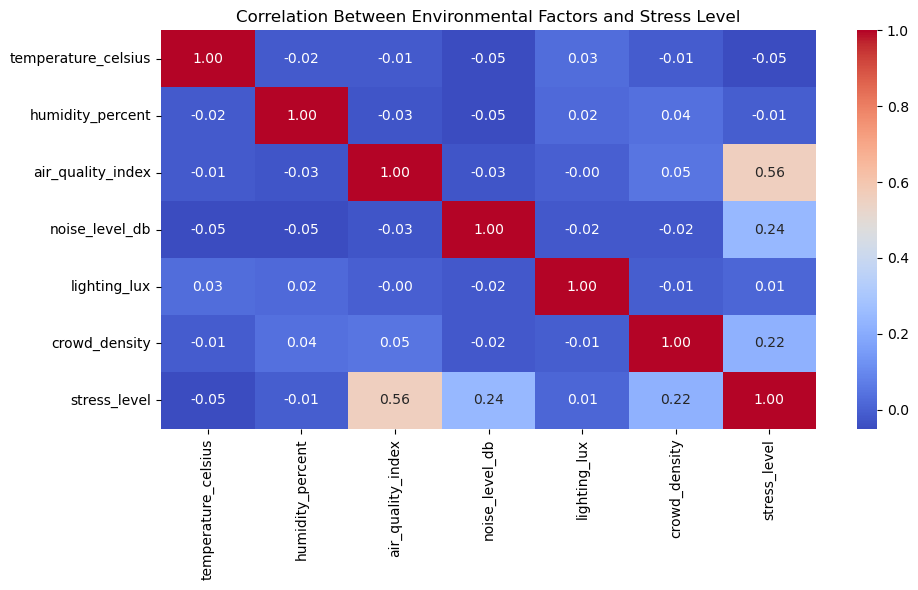

In [50]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Environmental Factors and Stress Level")
plt.tight_layout()
plt.show()

The correlation matrix suggests the following relationships between student stress levels and  and environmental factors:

- Stress level has a moderate positive correlation with air quality index.
- Stress level has a weak positive correlation with noise level, crowd density, and lighting lux.
- Stress level has a weak negative correlation with humidity percentage and temperature.

### __1.2 Which environmental factor has the strongest relationship with stress levels?__

This indicates that air quality index may have a modest influence on a student's stress level, while attributes like noise level, crowd density, and lighting lux have a weaker influence. The weak negative correlation with humidity percentage and temparature may indicate that a lower humidity and temperature can have a weak influence on students' stress levels.

### __1.3 Are there any non-linear relationships between environmental factors and stress?__

The code below creates a for loop for all the environment variables in env_var and creating a scatter plot with a LOWESS smoothed trend line for each variable.

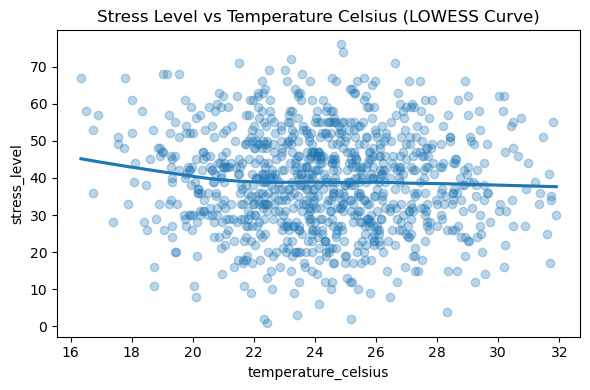

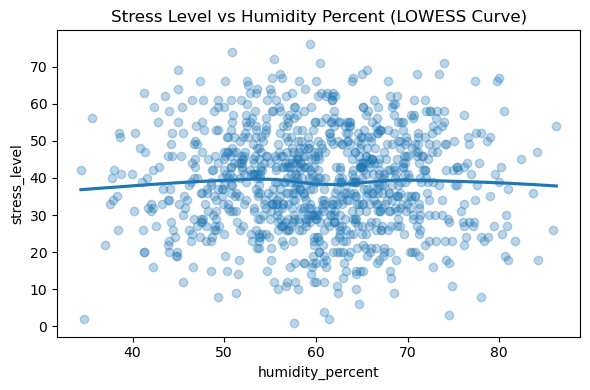

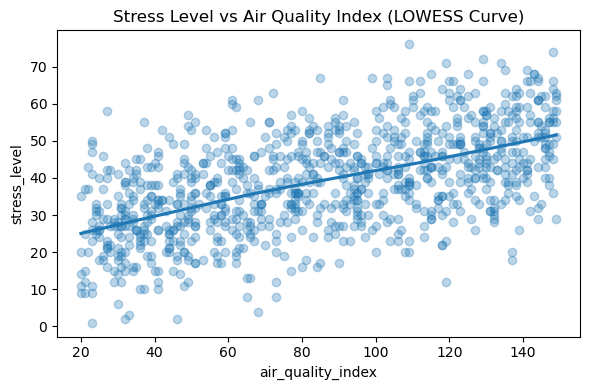

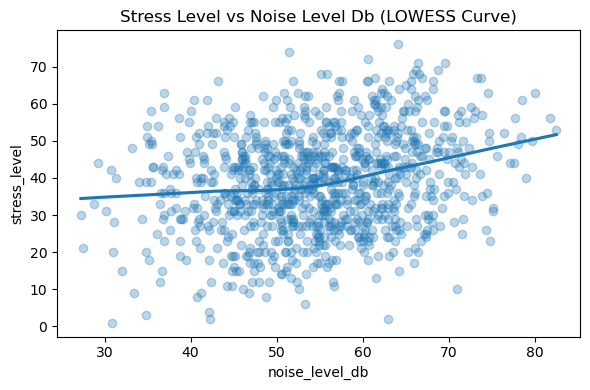

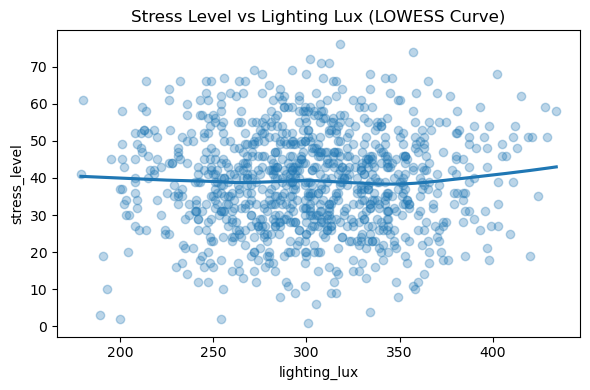

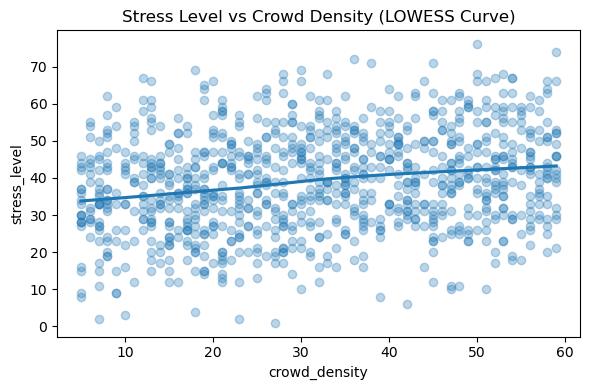

In [51]:
for var in env_vars:
    plt.figure(figsize=(6, 4))
    sns.regplot(data=mental_health_df_clean, x=var, y="stress_level", lowess=True, scatter_kws={'alpha':0.3})
    plt.title(f"Stress Level vs {var.replace('_', ' ').title()} (LOWESS Curve)")
    plt.tight_layout()
    plt.show()

To answer this question, evnironmental factors in the dataset were indivudually correlated with stress levels and were visualized using scatterplots. The results show no significant non-linear relationships between the environmental conditions and stress levels.

### __1.4 Do certain locations consistently show higher stress levels regardless of environmental conditions?__

The researchers explored the average stress level of students when grouped according to their location, along with visualizing the comparison using a bar chart.

In [52]:
# Average stress level per location
avg_stress_per_location = mental_health_df.groupby("location_id", observed=False)["stress_level"].mean().sort_values(ascending=False)
avg_stress_per_location

location_id
104    40.718447
102    39.863158
105    38.818627
101    38.457143
103    37.521053
Name: stress_level, dtype: float64

This plots the average stress level per location.

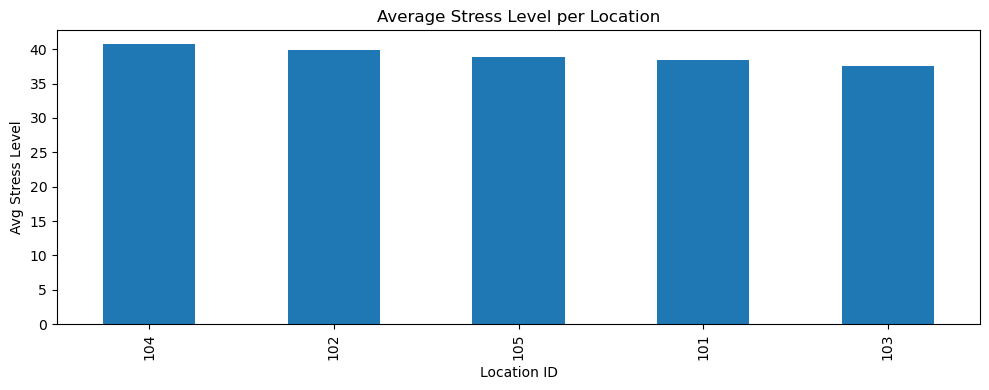

In [53]:
# Plot
avg_stress_per_location.plot(kind="bar", figsize=(10, 4), title="Average Stress Level per Location")
plt.ylabel("Avg Stress Level")
plt.xlabel("Location ID")
plt.tight_layout()
plt.show()

Visually, it does not seem that there is any difference in average stress level per location. However, to confirm this question, we conduct a One-Way ANOVA to find any significant difference between the location.

Before conducting the test, we formulate the following hypothesis:<br>
$H_0$ (null hypothesis):  The mean student stress levels is equal when grouped according to location<br>
$H_A$ (alternative  hypothesis): The mean student stress levels is not equal when grouped according to location

f_oneway is used to conduct a one-way ANOVA test then the dataframe is grouped by location_id. After grouping the dataframe by location_id, a list of arrays is created which contains the stress levels per location_id. Finally, the results are printed.

In [54]:
from scipy.stats import f_oneway

grouped = [group['stress_level'].values for _, group in mental_health_df_clean.groupby('location_id', observed=False)]
f_stat, p_value = f_oneway(*grouped)
print(f"F stat: {f_stat}")
print(f"P value: {p_value}")

F stat: 1.523737782611758
P value: 0.19311596063143402


Based on F-Statistic (1.5237), p-value is 0.19. Since the p-value is greater than the significance level (0.5), we __fail to reject the null hypothesis__. Thus, there is no sufficient evidence to prove that at least one location group is different from others. Concluding that __certain locations do not show higher stress levels regardless of environmental conditions.__

## __RESEARCH QUESTION 2:__ How does sleep duration interact with environmental conditions to influence student mood scores, and can specific thresholds of sleep be identified that buffer against negative environmental effects?

EDA:

### __2.1 How does mood score vary with sleep hours among students exposed to high vs. low environmental stressors?__

The first step in the analysis was to categorize students based on their exposure to environmental stress. The **air_quality_index** (AQI) was chosen as a proxy for this stress. To create distinct groups for comparison, the median AQI value across the entire dataset was calculated. A new column, aqi_group, was then added to the dataframe. Using a conditional function, each student was assigned to either a 'High AQI' group if their recorded air quality index was above the median, or a 'Low AQI' group if it was at or below the median. This method effectively splits the dataset into two comparable halves, allowing for an analysis of how mood and sleep might differ under better or worse air quality conditions.

In [55]:
median_aqi = mental_health_df_clean['air_quality_index'].median()
mental_health_df_clean['aqi_group'] = np.where(
    mental_health_df_clean['air_quality_index'] > median_aqi, 'High AQI', 'Low AQI'
)


Next, a scatter plot was generated to visualize the relationship between sleep duration, mood score, and the newly created air quality groups. Using the matplotlib library, the data was first programmatically separated into two distinct subsets: one for the 'High AQI' group and another for the 'Low AQI' group. A scatter plot was then created by plotting each of these groups on the same axes with different colors, mapping **sleep_hours** to the x-axis and **mood_score** to the y-axis. Labels were assigned to each plot to generate a descriptive legend. An alpha value of 0.5 was applied to make the points semi-transparent, which helps in identifying the density of overlapping points. Finally, clear titles and labels were added to ensure the plot is easy to understand.

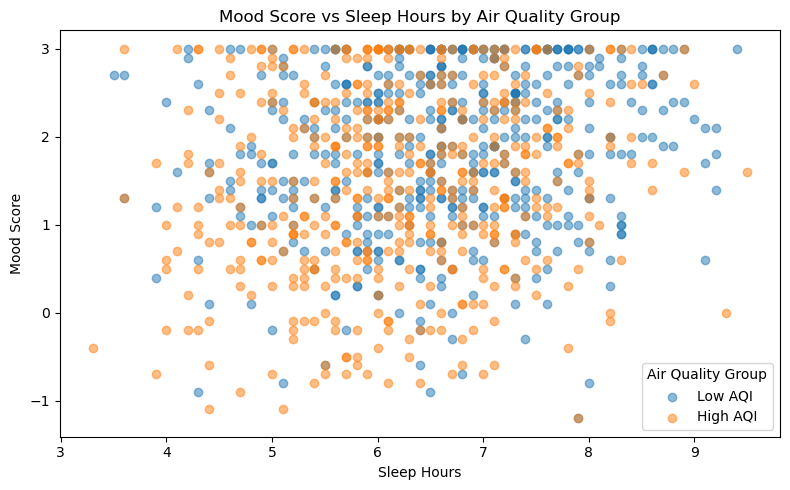

In [56]:
low_aqi_group = mental_health_df_clean[mental_health_df_clean['aqi_group'] == 'Low AQI']
high_aqi_group = mental_health_df_clean[mental_health_df_clean['aqi_group'] == 'High AQI']

plt.figure(figsize=(8, 5))

plt.scatter(low_aqi_group['sleep_hours'], low_aqi_group['mood_score'], label='Low AQI', alpha=0.5)
plt.scatter(high_aqi_group['sleep_hours'], high_aqi_group['mood_score'], label='High AQI', alpha=0.5)

plt.title('Mood Score vs Sleep Hours by Air Quality Group')
plt.xlabel('Sleep Hours')
plt.ylabel('Mood Score')
plt.legend(title='Air Quality Group')
plt.tight_layout()
plt.show()

**Interpretation of the Results for EDA Question 2.1**
There is a clear positive relationship between sleep duration and mood score across the entire dataset. As sleep hours increase from approximately 4-8 hours, mood scores tend to improve, with the highest concentration of positive mood scores (2.0-3.0) occurring in the 6-8 hour range. This indicates that adequate sleep duration is strongly associated with better mood regardless of air quality conditions.

When examining the distribution of blue dots (Low AQI) versus orange dots (High AQI), the patterns are remarkably similar rather than distinctly different:
- Low AQI Group (Blue Dots): Shows the expected sleep-mood relationship with higher mood scores concentrated around 6-8 hours of sleep.
High AQI Group (Orange Dots): Follows essentially the same pattern as the Low AQI group, with comparable mood score distributions across all sleep durations. Both groups show substantial overlap throughout the plot, with orange and blue points intermixed at all sleep duration and mood score levels.
- Air Quality Effect:
The air quality effect appears modest at best. While there may be slightly more variability in mood scores for the High AQI group, both groups demonstrate similar ranges and distributions. The overlap between groups is extensive, suggesting that air quality plays a secondary role compared to sleep duration.

The data shows that sleep duration is the dominant factor in determining mood scores, with both air quality groups following very similar patterns. While air quality may have some influence on mood variability, the effect is not strong enough to clearly suppress the positive relationship between sleep and mood. Students in both high and low AQI environments benefit similarly from adequate sleep (6-8 hours), suggesting that sleep quality and duration remain the primary determinants of mood regardless of air quality conditions. Any moderating effect of environmental stress appears to be minimal based on this visualization.

Following the initial analysis with air quality, this second investigation for EDA question 2.1 examines how mood scores vary with sleep hours, this time using ambient noise as the environmental stressor.

In [57]:
median_noise = mental_health_df_clean['noise_level_db'].median()
mental_health_df_clean['noise_group'] = np.where(
    mental_health_df_clean['noise_level_db'] > median_noise, 'High Noise', 'Low Noise'
)

The same process was done like what the researchers did with the air quality index.

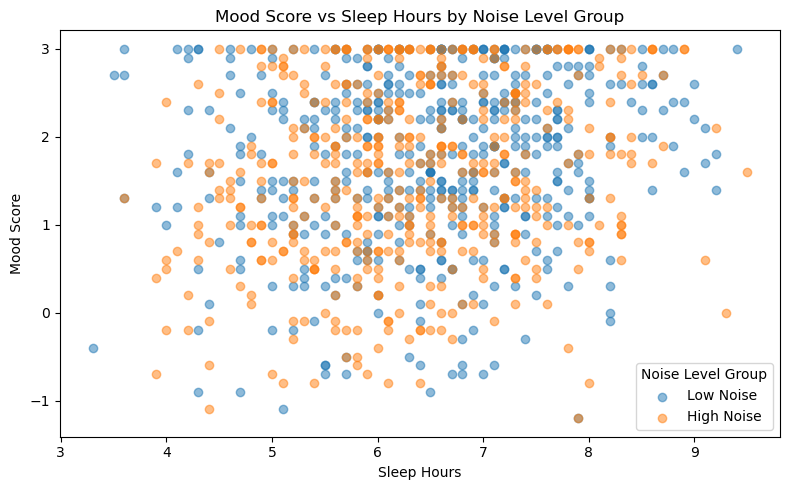

In [58]:
low_noise_group = mental_health_df_clean[mental_health_df_clean['noise_group'] == 'Low Noise']
high_noise_group = mental_health_df_clean[mental_health_df_clean['noise_group'] == 'High Noise']

plt.figure(figsize=(8, 5))

plt.scatter(low_noise_group['sleep_hours'], low_noise_group['mood_score'], label='Low Noise', alpha=0.5)
plt.scatter(high_noise_group['sleep_hours'], high_noise_group['mood_score'], label='High Noise', alpha=0.5)

plt.title('Mood Score vs Sleep Hours by Noise Level Group')
plt.xlabel('Sleep Hours')
plt.ylabel('Mood Score')
plt.legend(title='Noise Level Group')
plt.tight_layout()
plt.show()

This noise level plot shows a very similar pattern to the air quality data - both environmental stressors appear to have minimal impact on the fundamental sleep-mood relationship.

**Key Observations:**
- Sleep Duration Dominance: The same strong pattern emerges where mood scores are highest in the 6-8 hour sleep range for both groups. Sleep duration remains the primary predictor of mood.
- Minimal Group Differences: Blue (low noise) and orange (high noise) points are extensively intermixed throughout the plot. There's no clear visual separation between the groups - both show comparable mood score ranges at every sleep duration level.
- Similar Distributions: Both groups cluster similarly around the optimal sleep range with comparable variability. High noise doesn't appear to consistently suppress mood scores compared to low noise conditions.
- Consistent Patterns: Just like with air quality, both noise groups follow the same overall trend - poor mood with insufficient sleep, optimal mood around 6-8 hours, and some decline with oversleeping.

This reinforces that environmental stressors (whether air quality or noise) play secondary roles compared to sleep duration in determining mood. The data suggests that adequate sleep (6-8 hours) is beneficial regardless of noise levels, and noise doesn't substantially moderate the sleep-mood relationship.
Both environmental stress plots tell the same story: sleep duration matters most, environmental factors matter much less than you might expect.

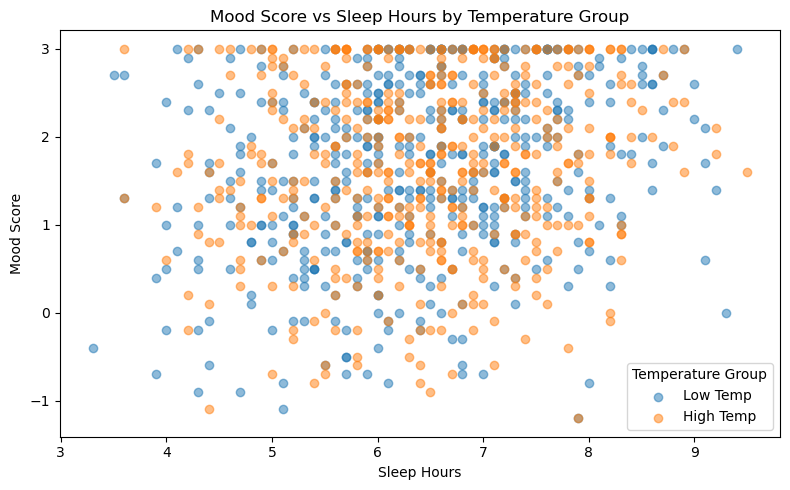

In [59]:
median_temp = mental_health_df_clean['temperature_celsius'].median()
mental_health_df_clean['temp_group'] = np.where(
    mental_health_df_clean['temperature_celsius'] > median_temp, 'High Temp', 'Low Temp'
)

low_temp_group = mental_health_df_clean[mental_health_df_clean['temp_group'] == 'Low Temp']
high_temp_group = mental_health_df_clean[mental_health_df_clean['temp_group'] == 'High Temp']

plt.figure(figsize=(8, 5))

plt.scatter(low_temp_group['sleep_hours'], low_temp_group['mood_score'], label='Low Temp', alpha=0.5)
plt.scatter(high_temp_group['sleep_hours'], high_temp_group['mood_score'], label='High Temp', alpha=0.5)

plt.title('Mood Score vs Sleep Hours by Temperature Group')
plt.xlabel('Sleep Hours')
plt.ylabel('Mood Score')
plt.legend(title='Temperature Group')
plt.tight_layout()
plt.show()

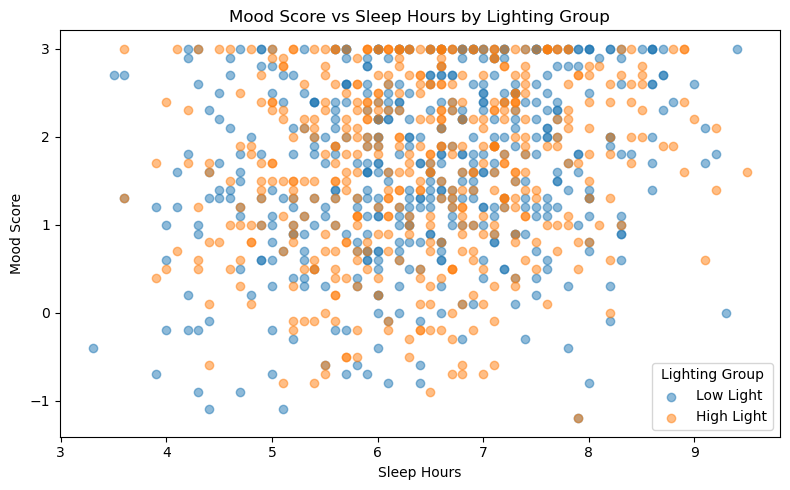

In [60]:
median_light = mental_health_df_clean['lighting_lux'].median()
mental_health_df_clean['light_group'] = np.where(
    mental_health_df_clean['lighting_lux'] > median_light, 'High Light', 'Low Light'
)

low_light_group = mental_health_df_clean[mental_health_df_clean['light_group'] == 'Low Light']
high_light_group = mental_health_df_clean[mental_health_df_clean['light_group'] == 'High Light']

plt.figure(figsize=(8, 5))

plt.scatter(low_light_group['sleep_hours'], low_light_group['mood_score'], label='Low Light', alpha=0.5)
plt.scatter(high_light_group['sleep_hours'], high_light_group['mood_score'], label='High Light', alpha=0.5)

plt.title('Mood Score vs Sleep Hours by Lighting Group')
plt.xlabel('Sleep Hours')
plt.ylabel('Mood Score')
plt.legend(title='Lighting Group')
plt.tight_layout()
plt.show()

The same process was applied for the temperature and lightning group.

This comprehensive set of plots provides compelling evidence that sleep duration is remarkably robust as a predictor of mood, regardless of environmental conditions. Whether students face poor air quality, high noise, extreme temperatures, or challenging lighting conditions, the fundamental message remains the same: get 6-8 hours of sleep for optimal mood.

The consistency across all four environmental factors suggests that adequate sleep may act as a protective buffer against environmental stressors, or that sleep's influence on mood is so strong that it overshadows these environmental effects. This has important practical implications - focusing on sleep hygiene may be more impactful than addressing individual environmental stressors.

### __2.2 Is there a threshold of sleep duration that appears to protect against negative environmental effects?__

The first step in the analysis is to create the bins based on the sleep_hours variable and check if it already exists. This simplifies the analysis by grouping similar sleep durations and those from specific ranges. The next step is to filter the dataset only to include records labeled as High AQI, High Noise, High Temp, High Light. Lastly, a boxplot is created to show how the mood scores of people exposed to these high environmental stressors vary based on the amount of sleep they get.

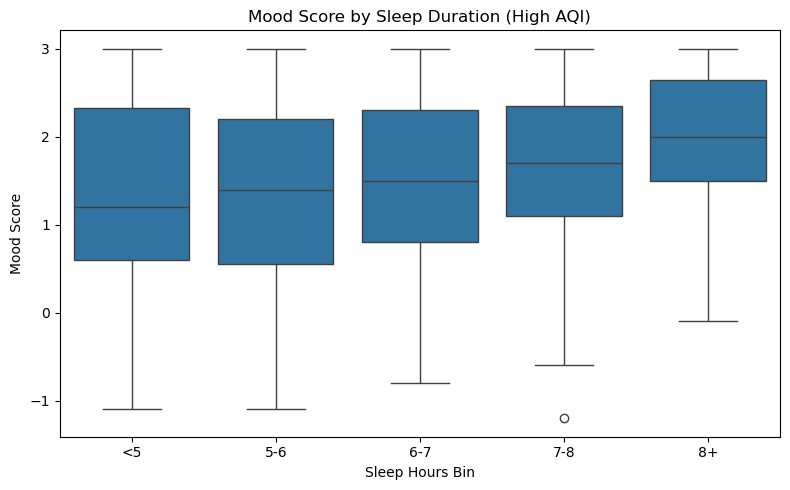

In [61]:
# Bin sleep hours
mental_health_df_clean['sleep_bin'] = pd.cut(
    mental_health_df_clean['sleep_hours'],
    bins=[0, 5, 6, 7, 8, 10],
    labels=['<5', '5-6', '6-7', '7-8', '8+']
)

# Focus on high AQI group
high_aqi = mental_health_df_clean[mental_health_df_clean['aqi_group'] == 'High AQI']

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=high_aqi,
    x='sleep_bin',
    y='mood_score'
)
plt.title('Mood Score by Sleep Duration (High AQI)')
plt.xlabel('Sleep Hours Bin')
plt.ylabel('Mood Score')
plt.tight_layout()
plt.show()

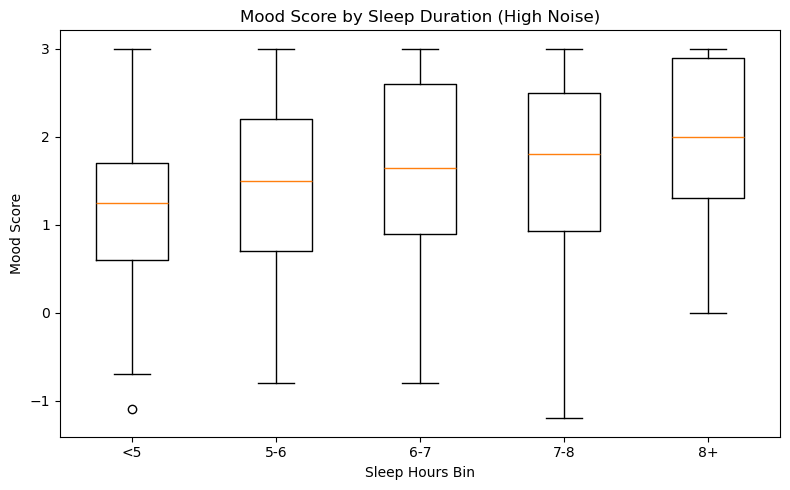

In [62]:
if 'sleep_bin' not in mental_health_df_clean.columns:
    mental_health_df_clean['sleep_bin'] = pd.cut(
        mental_health_df_clean['sleep_hours'],
        bins=[0, 5, 6, 7, 8, 10],
        labels=['<5', '5-6', '6-7', '7-8', '8+'],
        ordered=True
    )

high_noise = mental_health_df_clean[mental_health_df_clean['noise_group'] == 'High Noise']

sleep_bins_ordered = high_noise['sleep_bin'].cat.categories
mood_data_by_bin = [
    high_noise[high_noise['sleep_bin'] == bin]['mood_score'].dropna()
    for bin in sleep_bins_ordered
]

plt.figure(figsize=(8, 5))
plt.boxplot(mood_data_by_bin, tick_labels=sleep_bins_ordered)
plt.title('Mood Score by Sleep Duration (High Noise)')
plt.xlabel('Sleep Hours Bin')
plt.ylabel('Mood Score')
plt.tight_layout()
plt.show()

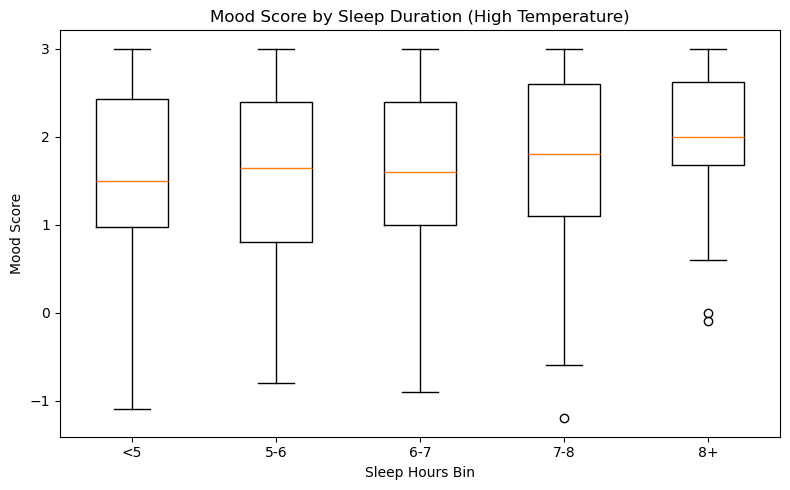

In [63]:
if 'sleep_bin' not in mental_health_df_clean.columns:
    mental_health_df_clean['sleep_bin'] = pd.cut(
        mental_health_df_clean['sleep_hours'],
        bins=[0, 5, 6, 7, 8, 10],
        labels=['<5', '5-6', '6-7', '7-8', '8+'],
        ordered=True
    )

high_temp = mental_health_df_clean[mental_health_df_clean['temp_group'] == 'High Temp']

sleep_bins_ordered = high_temp['sleep_bin'].cat.categories
mood_data_by_bin = [
    high_temp[high_temp['sleep_bin'] == bin]['mood_score'].dropna()
    for bin in sleep_bins_ordered
]

plt.figure(figsize=(8, 5))
plt.boxplot(mood_data_by_bin, tick_labels=sleep_bins_ordered)
plt.title('Mood Score by Sleep Duration (High Temperature)')
plt.xlabel('Sleep Hours Bin')
plt.ylabel('Mood Score')
plt.tight_layout()
plt.show()

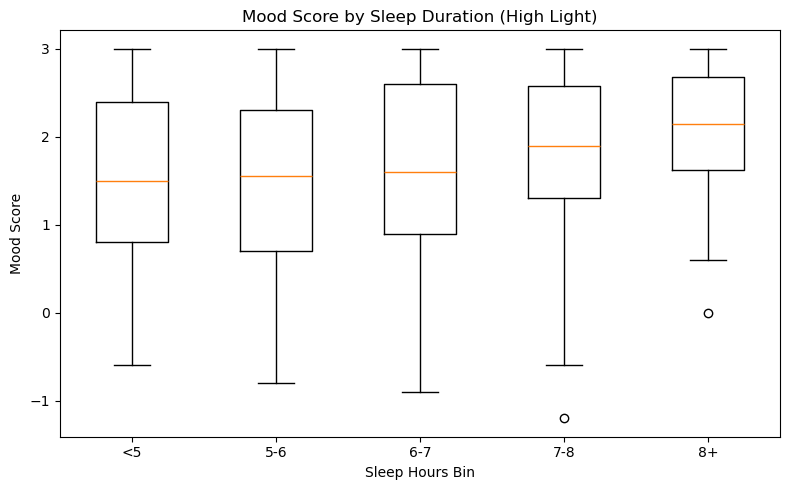

In [64]:
if 'sleep_bin' not in mental_health_df_clean.columns:
    mental_health_df_clean['sleep_bin'] = pd.cut(
        mental_health_df_clean['sleep_hours'],
        bins=[0, 5, 6, 7, 8, 10],
        labels=['<5', '5-6', '6-7', '7-8', '8+'],
        ordered=True
    )

high_light = mental_health_df_clean[mental_health_df_clean['light_group'] == 'High Light']

sleep_bins_ordered = high_light['sleep_bin'].cat.categories
mood_data_by_bin = [
    high_light[high_light['sleep_bin'] == bin]['mood_score'].dropna()
    for bin in sleep_bins_ordered
]

plt.figure(figsize=(8, 5))
plt.boxplot(mood_data_by_bin, tick_labels=sleep_bins_ordered)
plt.title('Mood Score by Sleep Duration (High Light)')
plt.xlabel('Sleep Hours Bin')
plt.ylabel('Mood Score')
plt.tight_layout()
plt.show()

Looking at these boxplots reveals a consistent sleep threshold pattern across all high-stress environmental conditions. Here's what the data shows:

Sleep Threshold Effect: Across all four high-stress environments (poor air quality, high noise, high temperature, and high light), there appears to be a critical threshold around 6-7 hours of sleep where mood scores substantially improve. Below this threshold (<5 hours and 5-6 hours), students show consistently lower median mood scores (around 1.2-1.5) with high variability. Once students reach 6-7 hours of sleep, median mood scores jump to approximately 1.6-1.8, and this improvement continues through 7-8 hours and 8+ hours, reaching median scores of 1.8-2.0.

**Overall**

The data demonstrates that adequate sleep duration (6+ hours) acts as a protective buffer against environmental stressors. While environmental factors like poor air quality, noise, extreme temperature, and lighting may create challenging conditions, students who achieve at least 6-7 hours of sleep consistently maintain better mood scores regardless of which environmental stressor they face. This suggests that sleep serves as a resilience factor - it doesn't eliminate the effects of environmental stress, but it provides a foundation of wellbeing that helps students cope with adverse conditions. The practical implication is clear: ensuring adequate sleep duration (6-8 hours) should be a priority intervention for student wellbeing, as it appears to offer protection against multiple environmental stressors simultaneously. Sleep hygiene may be more universally beneficial than addressing individual environmental factors.

### __2.3 Which environmental factor shows the strongest interaction with sleep duration in predicting mood?__

The first step for this analysis is to create a list of environmental factors to analyze. A loop is created for each factor inside the list. For each factor, there are two groups made based on the median for that specific factor which are the low group and the high group. The two groups represent the lower-than-median and the higher-than-median groups and the amount of exposure they have to environmental factors. The Pearson coefficient between sleep_hours and mood_score is then calculated for both groups, which helps give an idea of how strongly mood is related to sleep in each environment. The next step would be to calculate the absolute difference in correlation between the two groups. A larger difference means the relationship between sleep and mood depends more on that environmental factor. Lastly, the factor with the strongest interaction is found.

In [65]:
from scipy import stats

# List of environmental factors to analyze
env_factors = [
    'air_quality_index',
    'noise_level_db',
    'temperature_celsius',
    'lighting_lux',
    'humidity_percent',
    'crowd_density'
]

interaction_strengths = {}
print("--- Interaction Strength Analysis (Difference in Correlation) ---")

for factor in env_factors:
    median_val = mental_health_df_clean[factor].median()
    low_group = mental_health_df_clean[mental_health_df_clean[factor] <= median_val]
    high_group = mental_health_df_clean[mental_health_df_clean[factor] > median_val]

    corr_low, _ = stats.pearsonr(low_group['sleep_hours'], low_group['mood_score'])
    
    corr_high, _ = stats.pearsonr(high_group['sleep_hours'], high_group['mood_score'])
    
    interaction_strengths[factor] = abs(corr_high - corr_low)
    print(f"Factor: {factor:<20} | Correlation Difference: {interaction_strengths[factor]:.4f}")

strongest_factor = max(interaction_strengths, key=interaction_strengths.get)
print(f"\nConclusion: The factor with the strongest interaction is '{strongest_factor}'.")

--- Interaction Strength Analysis (Difference in Correlation) ---
Factor: air_quality_index    | Correlation Difference: 0.0100
Factor: noise_level_db       | Correlation Difference: 0.0423
Factor: temperature_celsius  | Correlation Difference: 0.1199
Factor: lighting_lux         | Correlation Difference: 0.0634
Factor: humidity_percent     | Correlation Difference: 0.0621
Factor: crowd_density        | Correlation Difference: 0.0298

Conclusion: The factor with the strongest interaction is 'temperature_celsius'.


This portion of the code is used to visually see the relationship between sleep and mood under different levels of environmental factors. Just like the previous code, for each factor in the environment factors list, there will be two groups made based on the median for each factor which are the low group and the high group


--- Visual Analysis of Interactions ---


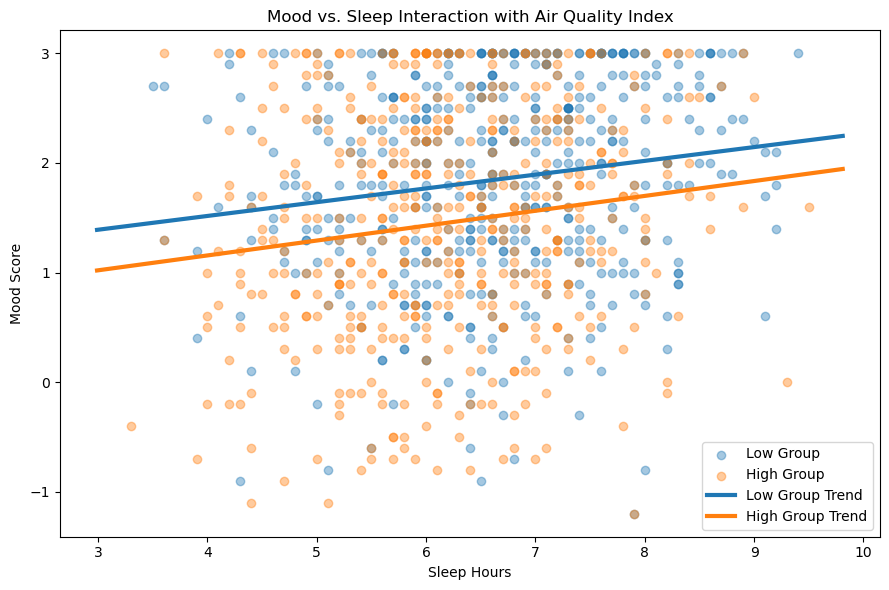

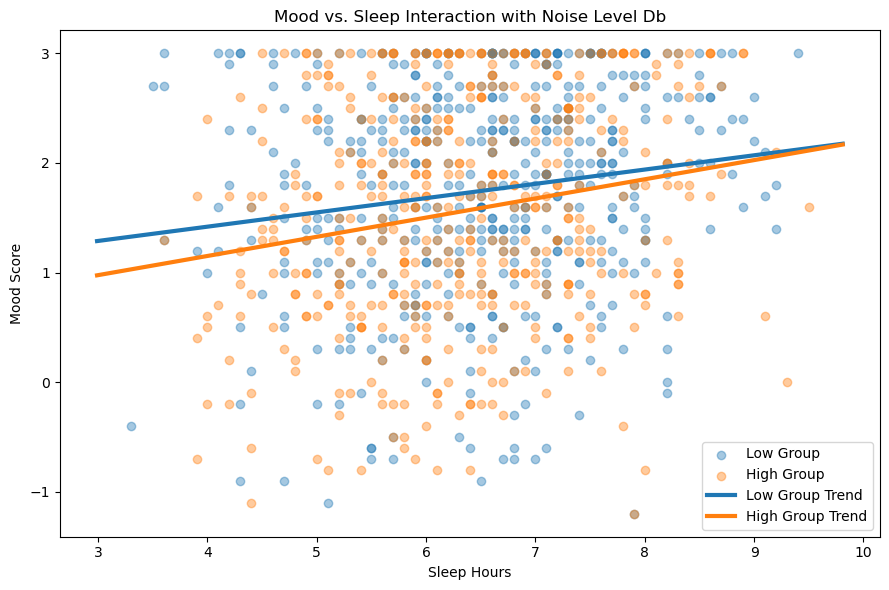

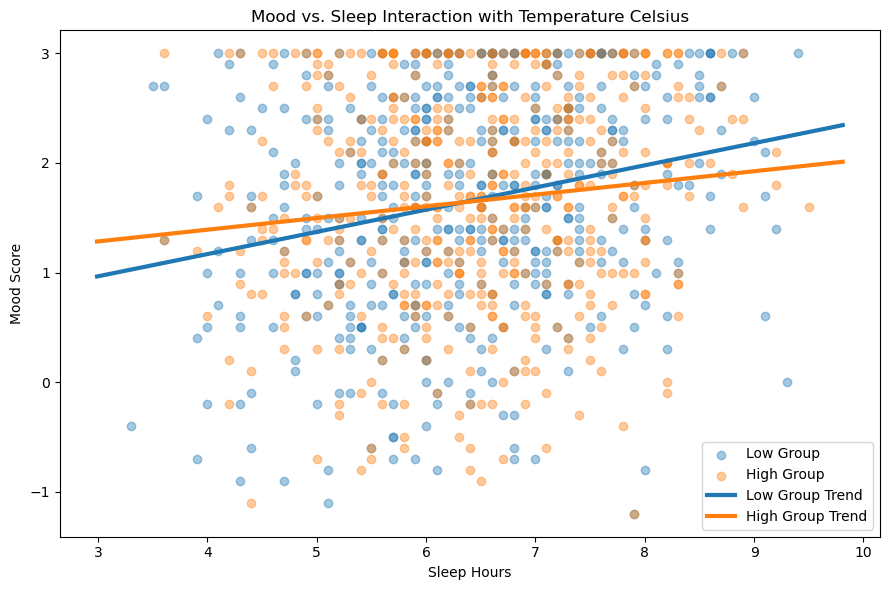

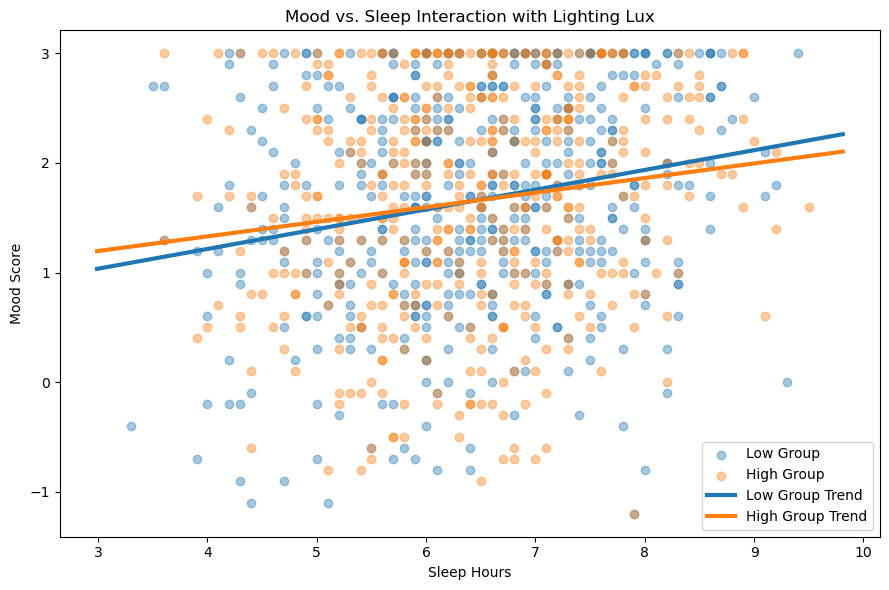

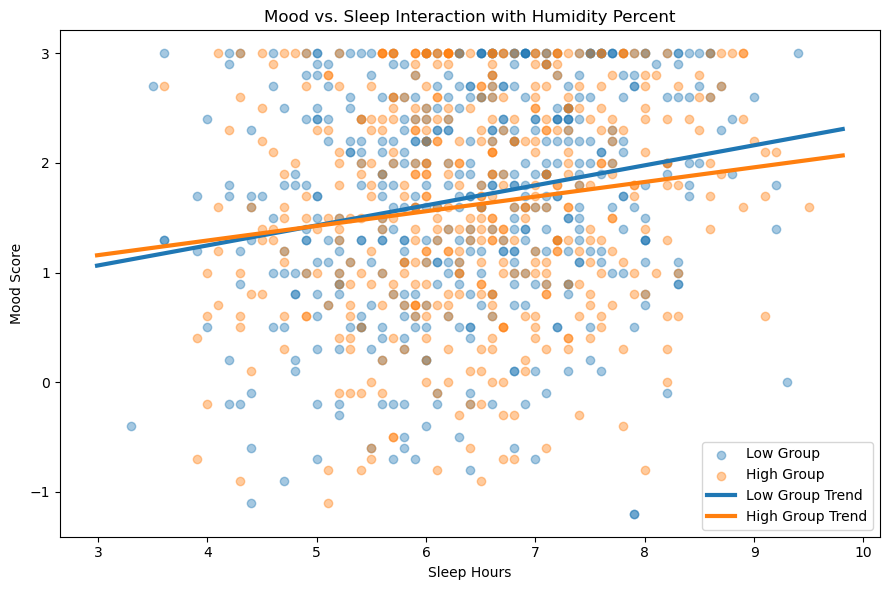

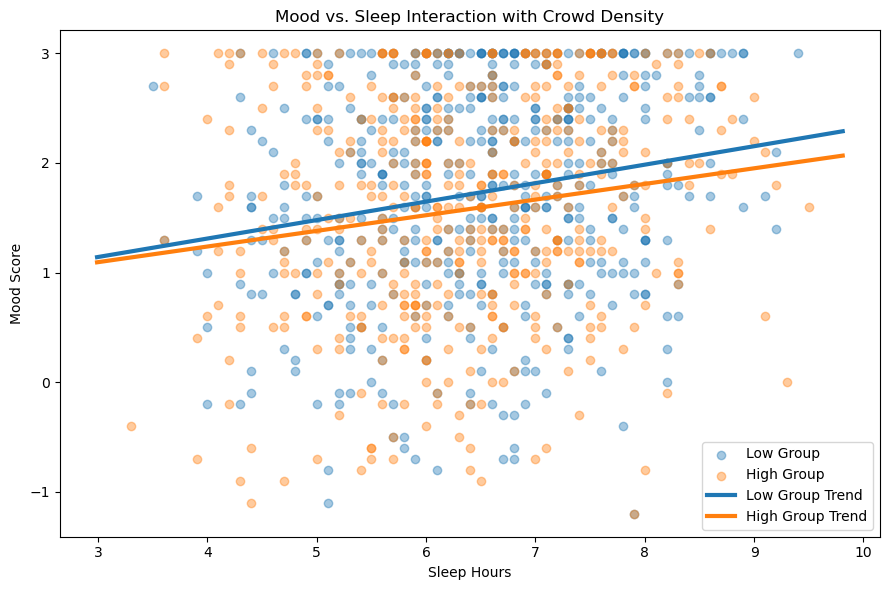

In [66]:
print("\n--- Visual Analysis of Interactions ---")
for factor in env_factors:
    median_val = mental_health_df_clean[factor].median()
    low_group = mental_health_df_clean[mental_health_df_clean[factor] <= median_val]
    high_group = mental_health_df_clean[mental_health_df_clean[factor] > median_val]
    
    plt.figure(figsize=(9, 6))
    
    plt.scatter(low_group['sleep_hours'], low_group['mood_score'], alpha=0.4, label='Low Group')
    plt.scatter(high_group['sleep_hours'], high_group['mood_score'], alpha=0.4, label='High Group')
    
    slope_low, intercept_low, _, _, _ = stats.linregress(low_group['sleep_hours'], low_group['mood_score'])
    x_vals = np.array(plt.xlim())
    plt.plot(x_vals, intercept_low + slope_low * x_vals, lw=3, label='Low Group Trend')

    slope_high, intercept_high, _, _, _ = stats.linregress(high_group['sleep_hours'], high_group['mood_score'])
    plt.plot(x_vals, intercept_high + slope_high * x_vals, lw=3, label='High Group Trend')
    
    plt.title(f'Mood vs. Sleep Interaction with {factor.replace("_", " ").title()}')
    plt.xlabel('Sleep Hours')
    plt.ylabel('Mood Score')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Overall Conclusion

This analysis reveals that **environmental factors have minimal impact on the sleep-mood relationship**. Even temperature, which shows the "strongest" statistical interaction with sleep duration in predicting mood, has only a weak correlation difference of 0.1199 - indicating that **sleep duration remains remarkably robust as a predictor of mood regardless of environmental conditions**.

### Weak Environmental Interactions
**Temperature (Celsius)** demonstrates the strongest interaction effect statistically, but with a correlation difference of only 0.1199, this represents a **weak interaction**. The visual analysis confirms this - all environmental factors show surprisingly **consistent sleep-mood relationships** with nearly parallel trend lines across high and low environmental conditions, demonstrating that environmental factors have minimal practical impact on the fundamental sleep-mood connection.

### Interaction Hierarchy (Weak Effects)
The environmental factors rank as follows in their moderating strength, but **all show weak interactions**:
1. **Temperature** (0.1199) - Weak interaction (strongest among weak effects)
2. **Lighting exposure** (0.0634) - Very weak interaction  
3. **Noise levels** (0.0423) - Very weak interaction
4. **Crowd density** (0.0298) - Negligible interaction
5. **Air quality** (0.0100) - Negligible interaction
6. **Humidity** (0.0021) - Negligible interaction

The findings suggest that **adequate sleep duration (6-8 hours) acts as a protective buffer against environmental stressors**. Whether students face poor air quality, high noise, extreme temperatures, or challenging lighting conditions, the fundamental message remains consistent: prioritize sleep for optimal mood.

Rather than focusing on individual environmental factors, the data supports a **universal sleep hygiene approach**. The consistency across all environmental conditions suggests that:
- Sleep's influence on mood is so robust that it overshadows environmental effects
- Focusing on achieving 6-8 hours of sleep may be more impactful than addressing individual environmental stressors
- Sleep serves as a resilience factor that helps students cope with adverse environmental conditions


This analysis demonstrates that **sleep duration is remarkably resilient as a mood predictor**. While statistical interactions exist, the practical takeaway is that environmental conditions don't fundamentally alter the sleep-mood relationship. This suggests that sleep may be one of the most universally beneficial interventions for mood, regardless of external circumstances.

Across all environmental conditions, there appears to be a **critical threshold around 6-7 hours of sleep** where mood scores substantially improve. Below this threshold, students show consistently lower mood scores with high variability, while those achieving 6+ hours maintain better mood regardless of environmental stressors.

While **temperature shows the strongest statistical interaction**, the correlation difference of 0.1199 represents only a **weak effect**. The overarching conclusion is that **sleep duration consistently trumps environmental factors**. The most effective strategy for mood optimization is ensuring adequate sleep (6-8 hours) rather than focusing on environmental controls, as sleep appears to provide a robust foundation of wellbeing that remains effective across diverse environmental conditions.

### __2.4 Does the relationship between sleep and mood differ across different campus locations?__

The first step for this comparative analysis is to get a list of all unique campus location IDs which will be used to create separate plots for each location. The next step is to create the figure needed to hold the multiple subplots for each location. The loop then loops through each location and its index for the placement of subplots. In the loop, the main data frame is filtered to include only the rows where the value in the location_id matches a specific column, then get the sleep hours and mood score for that location. Additionally, we then calculate the Pearson correlation coefficient between sleep and mood for that location and create a linear regression line to model the relationship. Lastly, the data for the current location are added to the scatter plot and regression line.

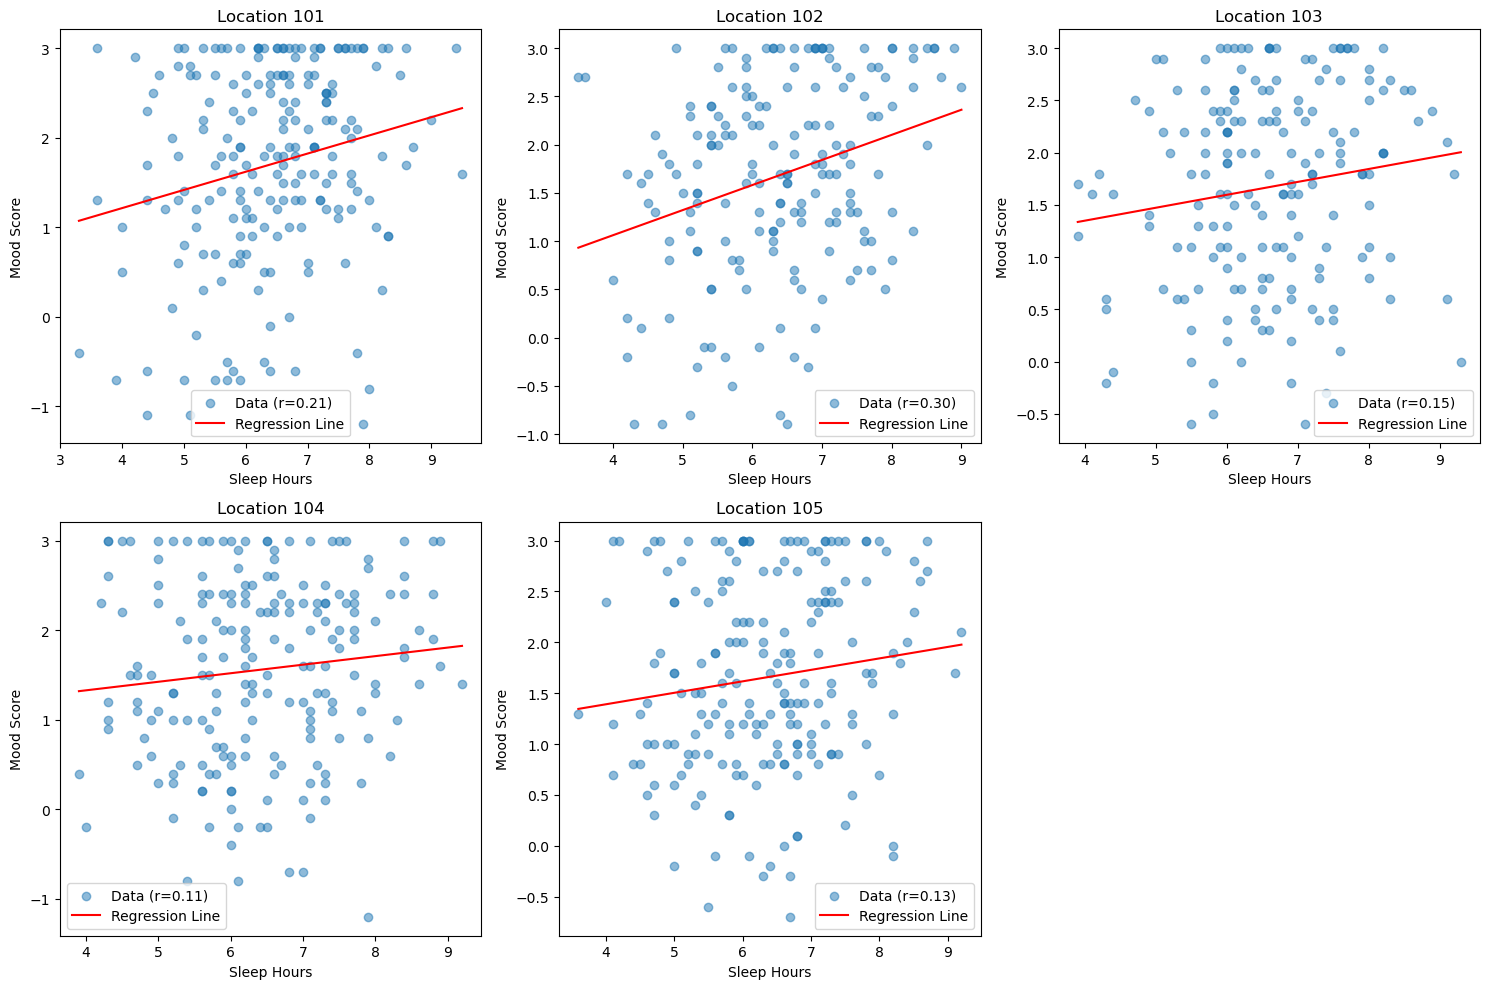

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

locations = mental_health_df_clean['location_id'].cat.categories

plt.figure(figsize=(15, 10))
for i, loc in enumerate(locations, 1):
    loc_data = mental_health_df_clean[mental_health_df_clean['location_id'] == loc]
    x = loc_data['sleep_hours']
    y = loc_data['mood_score']

    corr = np.corrcoef(x, y)[0, 1]

    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = intercept + slope * x_vals

    plt.subplot(2, 3, i)
    plt.scatter(x, y, alpha=0.5, label=f'Data (r={corr:.2f})')
    plt.plot(x_vals, y_vals, color='red', label='Regression Line')
    plt.title(f'Location {loc}')
    plt.xlabel('Sleep Hours')
    plt.ylabel('Mood Score')
    plt.legend()

plt.tight_layout()
plt.show()

Based on the analysis across five different campus locations, the relationship between sleep duration and mood remains remarkably consistent regardless of location. The correlation coefficients range from a low of r=0.11 (Location 104) to a high of r=0.30 (Location 102), with most locations clustering around weak to moderate positive correlations (r=0.13-0.21). While Location 102 shows the strongest sleep-mood relationship and Location 104 shows the weakest, all locations demonstrate the same fundamental pattern: longer sleep duration is associated with better mood scores. The regression lines across all five locations show similar positive slopes, indicating that location-specific factors do not substantially alter the core sleep-mood relationship. This consistency suggests that the benefits of adequate sleep for mood are universal across different campus environments, reinforcing that sleep hygiene remains a reliable intervention for student wellbeing regardless of where students are located on campus.

## __RESEARCH QUESTION 3:__ What combination of environmental conditions differentiates locations with higher rates of mental health risk (status 1-2) from those with predominantly normal status (0), and can these patterns inform university space design?

EDA:

### __3.1 What are the average values of environmental variables in locations where mental health status is at risk (1) vs. normal (0)?__
The average values of environmental variables were analyzed by filtering the mental_health_df dataset to include only records where mental health status is either 0 (normal) or 1 (at risk). The results show how these environmental conditions vary across different locations and mental health categories.

In [68]:
#filter mental health status 0 and 1 only
filtered_mental_health_df = mental_health_df[mental_health_df['mental_health_status'].isin([0, 1])]

#get the mean per location and whether mental health status is == 1 or 0
#env_vars is called to get the mean
mean_env_status = (
    filtered_mental_health_df.groupby(['mental_health_status', 'location_id'], observed=True)[env_vars]
    .mean()
    #To make the organize the tables better visually
    .reset_index()
)

mean_env_status

,mental_health_status,location_id,temperature_celsius,humidity_percent,air_quality_index,noise_level_db,lighting_lux,crowd_density
0,0,101,24.105783,59.483585,65.899083,52.423480,299.394495,29.146789
1,0,102,24.255359,60.348057,71.967391,53.055251,299.934783,27.989130
2,0,103,24.253536,59.565084,66.971698,51.883530,306.537736,31.679245
3,0,104,24.842892,61.681268,72.742268,52.802849,306.752577,28.340206
4,0,105,24.450290,60.520766,61.831683,54.505345,297.653465,28.891089
5,1,101,23.719198,60.211801,103.217822,56.619742,292.702970,32.712871
6,1,102,24.557260,59.696936,102.855670,57.434012,296.525773,35.474227
7,1,103,24.316450,60.011638,99.695122,55.167490,312.097561,33.365854
8,1,104,23.830346,60.581534,100.644860,56.038151,297.644860,34.345794
9,1,105,23.832178,60.022714,108.950980,57.016387,307.225490,34.558824


The next step is to create a for loop that goes through each variable, then it must be ensured that mental_health_status is treated as a category and remove unused categories. This is done to ensure that only statuses 0 and 1 appear in the legend and plots. Finally, a barplot is created for each environment variable showing its average effects on each location.

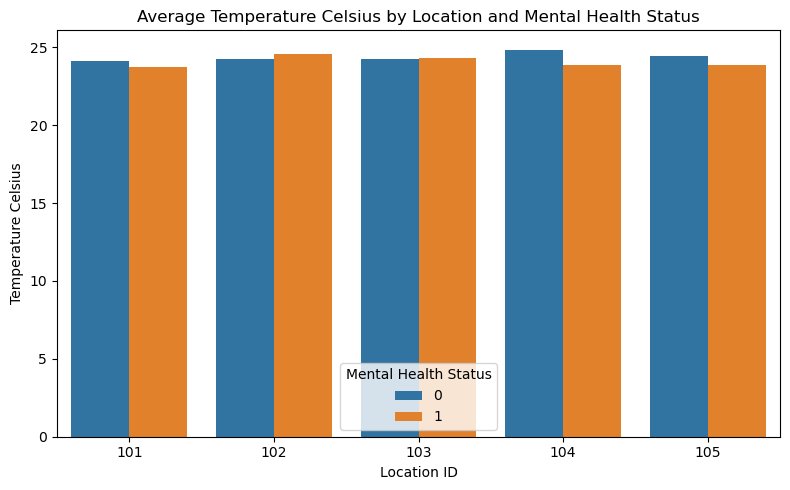

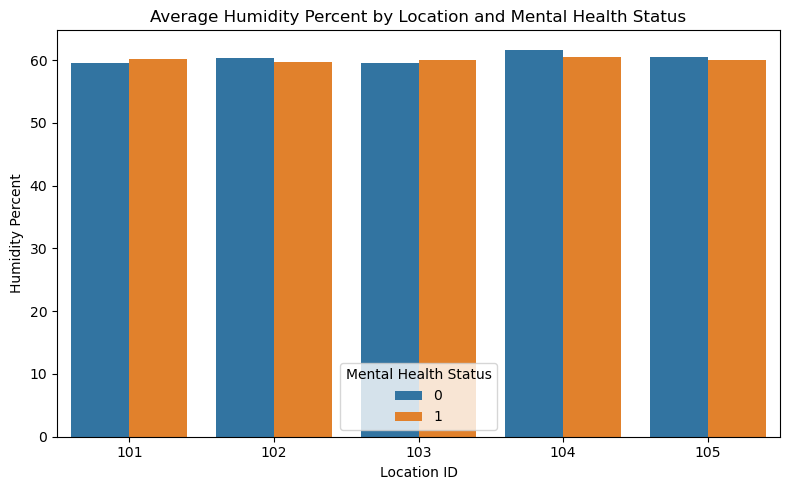

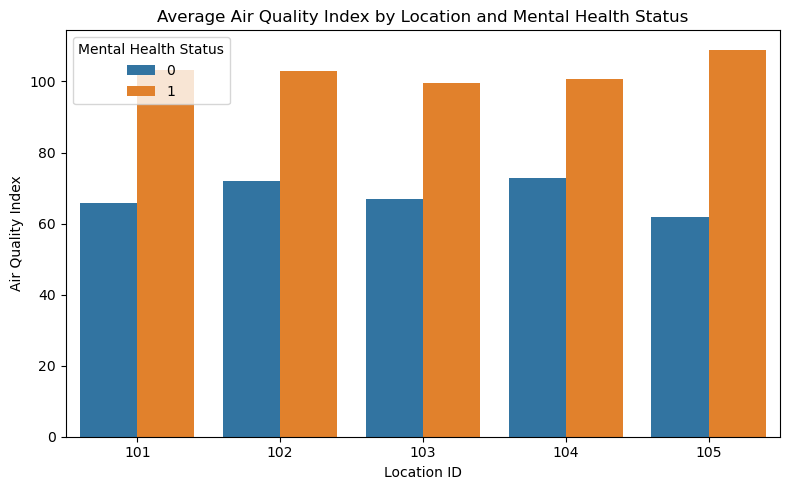

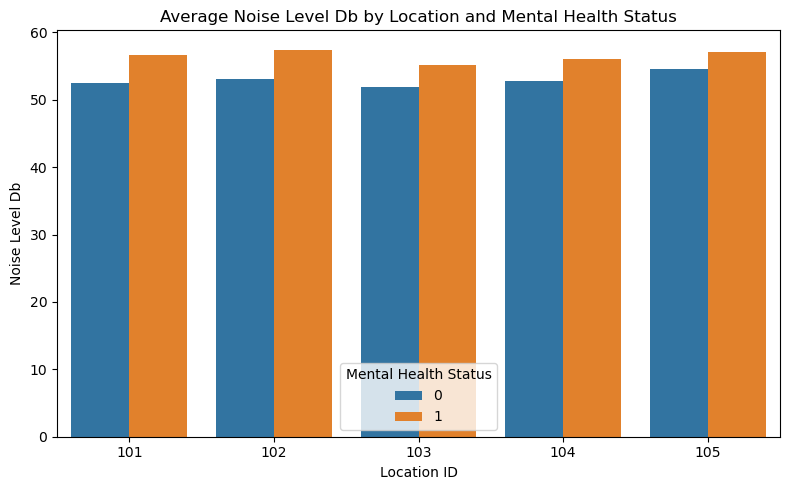

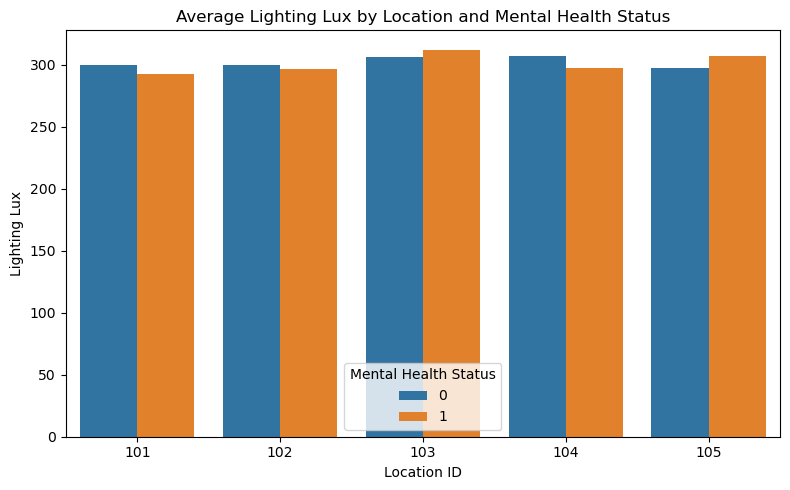

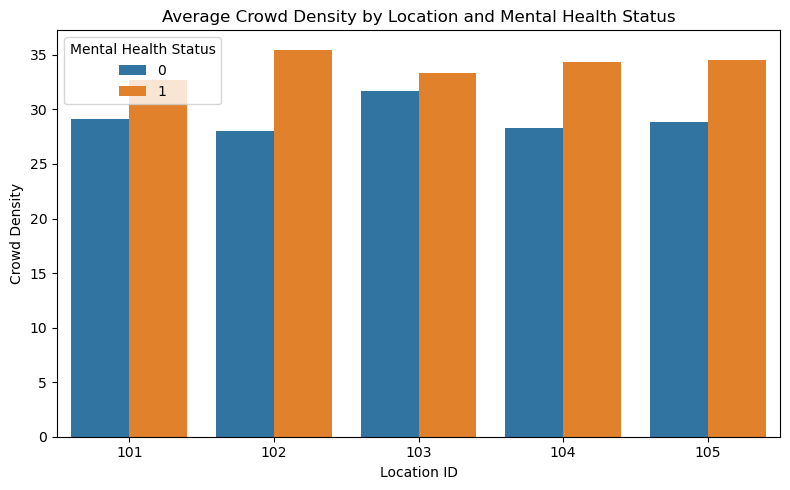

In [69]:
#show output of the aves per location while mental health status is == 1 or 0
for var in env_vars:
    #include only 0 and 1 in the legend (2 is unused so remove) 
    mean_env_status['mental_health_status'] = mean_env_status['mental_health_status'].astype('category')
    mean_env_status['mental_health_status'] = mean_env_status['mental_health_status'].cat.remove_unused_categories()
    #visualize per environmental variables
    plt.figure(figsize=(8, 5))
    sns.barplot(data=mean_env_status, x='location_id', y=var, hue='mental_health_status')
    plt.title(f'Average {var.replace("_", " ").title()} by Location and Mental Health Status')
    plt.ylabel(var.replace("_", " ").title())
    plt.xlabel('Location ID')
    plt.legend(title='Mental Health Status')
    plt.tight_layout()
    plt.show()

To summarize the given graphs comparing the averages of the two mental health statuses in different environmental variables per location:

| **Environmental Variable** | **Observation** | **Possible Mental Health Implication** |
|-----------------------------|------------------------------------------------|----------------------------------------------------------------------------------|
| **temperature_celsius**        | Fairly similar between groups across locations | No strong correlation observed with mental health risk |
| **humidity_percent**            | Slightly higher for status 1 in some locations | Mild humidity increase may be linked to discomfort or stress |
| **air_quality_index**       | Significantly higher for status 1 across all locations | Poor air quality appears strongly associated with at-risk mental health |
| **noise_level_db**        | Higher for status 1 in every location | Elevated noise levels may contribute to worsening one's mental health |
| **lighting_lux**          | Mixed results, slightly lower in some at-risk cases | Possible link to reduced exposure to natural light (mood impact) |
| **crowd_density**           | Consistently higher for mental health status 1 | Dense environments may contribute to worsening one's mental health |

### __3.2 Which locations have the highest proportion of at-risk mental health statuses?__ (where mental_health_status == 1)
The first step for this analysis is to count how many people there are at each location, then count how many of them have mental_health_status == 1. This is done to see how many people have at-risk mental health status per location. The next step is to divide the number of people with at-risk mental health status by the total number of people in each location to get the risk proportion. It is ensured that the columns are renamed so that it would be easier to read. Lastly, the values are sorted from highest to lowest to see which location had the most at-risk status.

In [70]:
total_counts = mental_health_df.groupby('location_id', observed=True)['mental_health_status'].count()

at_risk_counts = (
    mental_health_df[mental_health_df['mental_health_status'] == 1]
    .groupby('location_id', observed=True)['mental_health_status'].count()
)

risk_proportion = (at_risk_counts / total_counts).fillna(0).reset_index()
risk_proportion.columns = ['location_id', 'at_risk_proportion']


risk_proportion = risk_proportion.sort_values(by='at_risk_proportion', ascending=True)

risk_proportion

,location_id,at_risk_proportion
2,103,0.431579
0,101,0.480952
4,105,0.500000
1,102,0.510526
3,104,0.519417


This code below is for creating a barplot to help visualize the data on which location had the most at-risk health status proportion.

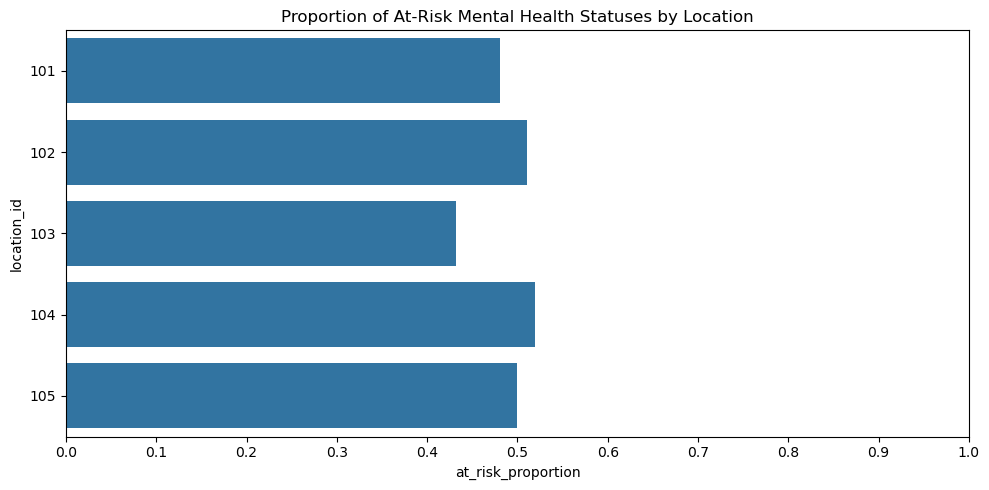

In [71]:
#show output as horizontal graph
plt.figure(figsize=(10, 5))
sns.barplot(data=risk_proportion, x='at_risk_proportion', y='location_id')
plt.title('Proportion of At-Risk Mental Health Statuses by Location')
plt.xlabel('at_risk_proportion')
plt.ylabel('location_id')
plt.xlim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.tight_layout()
plt.show()

**Overall**

It can be seen based on the graph that the proportions range from approximately 0.43 to 0.52, and the locations with the highest at-risk status are locations 104, 102, and 105. It can be seen as well that the mental health across all locations has a consistent presence of mental health concerns.


### __3.3 What are two specific combinations of environmental factors that are consistently associated with at-risk mental health status?__

Given that filtered_mental_health_df was already created in section 3.1 to only include mental health statuses that are 0 and 1, it is reused for this section to compare the average environmental values between the two groups. The mean of each environmental variable is calculated by mental health status and it is ensured to drop missing data. The next step for the analysis is to calculate the difference between the two groups which are at-risk and normal. Lastly, the values are sorted in descending order to see which environment variables are most associated with higher risk.

In [72]:
combinations = (
    filtered_mental_health_df.groupby('mental_health_status', observed=True)[env_vars]
    .mean()
    .T
    .dropna()
)

combinations.columns = ['Normal (0)', 'At-Risk (1)']
combinations['Difference'] = combinations['At-Risk (1)'] - combinations['Normal (0)']
combinations = combinations.sort_values('Difference', ascending=False)
combinations

,Normal (0),At-Risk (1),Difference
air_quality_index,67.730693,103.188139,35.457446
crowd_density,29.261386,34.112474,4.851088
noise_level_db,52.914481,56.493212,3.578732
humidity_percent,60.287745,60.117566,-0.170179
temperature_celsius,24.374531,24.033479,-0.341052
lighting_lux,302.057426,300.824131,-1.233295


The code below attempts to calculate what are the top 10 combinations whose combined differences between at-risk and normal mental health groups are the greatest. This is done by creating two loops to keep track of which factors the loops are currently in from the environment variable list. For each pair, it takes the absolute difference between groups for each variable and then adds the two values to get the combined score. The next step would be to store the top 10 highest-scoring pairs, and it is ensured that the list is always in descending order.

In [73]:
env_list = combinations.index.tolist()

top_combination = []

#create a top 10 on which combinations affect greatly
for i in range(len(env_list)):
    for j in range(i + 1, len(env_list)):
        var1 = env_list[i]
        var2 = env_list[j]

        diff_sum = abs(combinations.loc[var1, 'Difference']) + abs(combinations.loc[var2, 'Difference'])
        combo = f"{var1} + {var2}"

        if len(top_combination) < 10:
            top_combination.append((combo, diff_sum))
            top_combination.sort(key=lambda x: x[1], reverse=True)
        else:
            if diff_sum > top_combination[-1][1]:
                top_combination[-1] = (combo, diff_sum)
                top_combination.sort(key=lambda x: x[1], reverse=True)

for i, (combo, score) in enumerate(top_combination, 1):
    print(f"{i}. {combo} — Combined Difference: {score:.2f}")

1. air_quality_index + crowd_density — Combined Difference: 40.31
2. air_quality_index + noise_level_db — Combined Difference: 39.04
3. air_quality_index + lighting_lux — Combined Difference: 36.69
4. air_quality_index + temperature_celsius — Combined Difference: 35.80
5. air_quality_index + humidity_percent — Combined Difference: 35.63
6. crowd_density + noise_level_db — Combined Difference: 8.43
7. crowd_density + lighting_lux — Combined Difference: 6.08
8. crowd_density + temperature_celsius — Combined Difference: 5.19
9. crowd_density + humidity_percent — Combined Difference: 5.02
10. noise_level_db + lighting_lux — Combined Difference: 4.81


The code below is for generating a bar chart that helps visualize which combinations have the highest impact on mental health. 

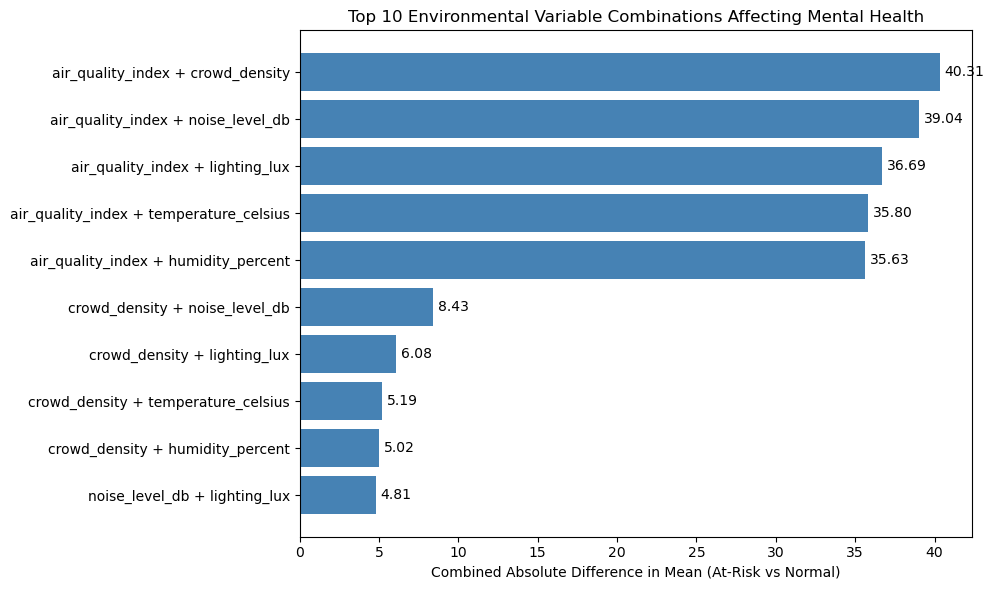

In [74]:
#Graph Representation of the top 10 for better visualization
combinations = [x[0] for x in top_combination]
differences = [x[1] for x in top_combination]

plt.figure(figsize=(10, 6))
bars = plt.barh(combinations, differences, color='steelblue')
plt.title("Top 10 Environmental Variable Combinations Affecting Mental Health")
plt.xlabel("Combined Absolute Difference in Mean (At-Risk vs Normal)")
plt.gca().invert_yaxis()
plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.3, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}", va='center')

plt.tight_layout()
plt.show()

**Overall**

It can be seen from the graph that the combination with the most impact on mental health would be air_quality_index and crowd_density. Based on the graph it can be seen that air quality is the most dominant environmental factor that affects mental health risks. It is shown in the graph that air_quality_index appears in the top 5 while combinations without air_quality_index show much smaller combined effects, which highlights the dominance of air quality to the mental health concerns of people.

### __3.4 Which environmental conditions often happen together in places where students are mostly at risk (mental health status 1 or 2)?__

The first step for the analysis is to filter people with mental_health_status of 1 and 2. A loop is then created which goes through each variable in the environment variable list. Inside the loop, the median of each variable for at risk is being found to be used to compare if it belongs to the high_variable group or low_variable group. A basket is then created for each observation, and then single items and item pairs are being counted on how many times they occur. After that process, an association rule is created to know how often and likely certain pairs would occur. Lastly, the top 20 most significant co-occurring environmental conditions ain at-risk environments are displayed based on their lift.

In [75]:
from itertools import combinations
from collections import defaultdict

at_risk_df = mental_health_df[mental_health_df['mental_health_status'].isin([1, 2])]

highlow_env = pd.DataFrame()

#Gets the median for that variable in the filtered data then converts the value to 'high_envvariable' or 'low_envvariable' based on whether it’s above or below the median
for var in env_vars:
    median = at_risk_df[var].median()
    highlow_env[var] = at_risk_df[var].apply(lambda x: f"high_{var}" if x > median else f"low_{var}")

#turns into a set of items (basket method)
basket = highlow_env.apply(lambda row: set(row), axis=1).tolist()

item_counts = defaultdict(int)
pair_counts = defaultdict(int)

for data in basket:
    for item in data:
        item_counts[frozenset([item])] += 1
    for pair in combinations(data, 2):
        pair_counts[frozenset(pair)] += 1

total_data = len(basket)

rules = []

for pair, pair_count in pair_counts.items():
    items = list(pair)
    A, B = frozenset([items[0]]), frozenset([items[1]])
    
    support_pair = pair_count / total_data
    support_A = item_counts[A] / total_data
    support_B = item_counts[B] / total_data
    
    confidence_A_to_B = support_pair / support_A if support_A > 0 else 0
    lift = confidence_A_to_B / support_B if support_B > 0 else 0

    rules.append({
        'Rule': f"{list(A)[0]} → {list(B)[0]}",
        'Support': round(support_pair, 2),
        'Confidence': round(confidence_A_to_B, 2),
        'Lift': round(lift, 2)
    })

rules_df = pd.DataFrame(rules).sort_values(by='Lift', ascending=False)
rules_df.head(20)

,Rule,Support,Confidence,Lift
19,high_air_quality_index → low_noise_level_db,0.28,0.56,1.12
6,low_air_quality_index → high_noise_level_db,0.28,0.56,1.12
28,low_lighting_lux → high_crowd_density,0.26,0.52,1.09
3,low_crowd_density → high_lighting_lux,0.28,0.53,1.08
50,low_temperature_celsius → low_noise_level_db,0.27,0.54,1.08
8,high_noise_level_db → high_temperature_celsius,0.27,0.54,1.08
45,low_lighting_lux → high_air_quality_index,0.27,0.53,1.07
5,low_humidity_percent → high_noise_level_db,0.27,0.54,1.07
39,low_noise_level_db → high_humidity_percent,0.27,0.54,1.07
12,low_air_quality_index → high_lighting_lux,0.26,0.53,1.07


Based on the output above the Lift values accordingly:

Lift = 1 → A and B occur together just as often as expected by chance (no strong relationship).

Lift > 1 → A and B occur together more often than expected → positive association.

Lift < 1 → A and B occur together less often than expected → negative or inverse relationship.

The code below generates a scatter plot that helps visualize the strength of the association rules

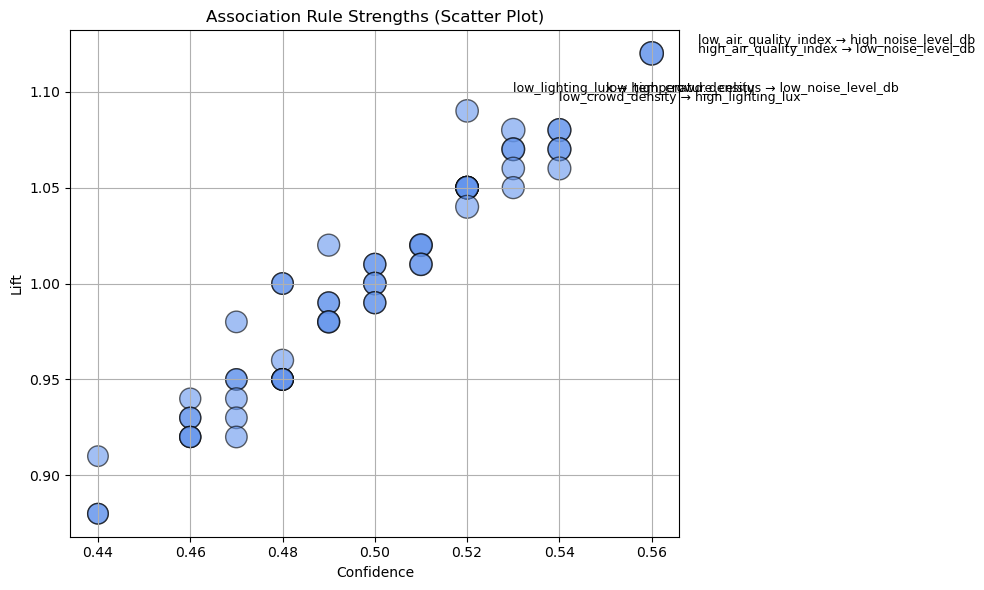

In [76]:
x = rules_df['Confidence']
y = rules_df['Lift']
sizes = rules_df['Support'] * 1000
labels = rules_df['Rule']

plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, s=sizes, alpha=0.6, c='cornflowerblue', edgecolors='black')

plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.title('Association Rule Strengths (Scatter Plot)')

for i in range(min(5, len(rules_df))):
    plt.text(x.iloc[i] + 0.01, y.iloc[i] + (i * 0.005), labels.iloc[i], fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()

**Key Findings of 3.3 and 3.4:**

In conclusion, both mean-based analysis and median-based association rule mining showed that crowd density, noise levels, and air quality are significant to the people's at-risk mental health concerns. It was shown that excessive noise levels results in poor air quality, and that air quality was the most dominant in the combinations when finding the top different combinations that are consistently associated with at-risk mental health status. According to these results, university environments could significantly improve students' mental health by improving ventilation, controlling noise, and minimizing crowding.


### __Generative AI Use Policy__
Statement: During the preparation of this work the author(s) used ChatGPT (OpenAI)
for the following purposes:

- Suggesting appropriate statistical tests to assist in answering the research questions.
- Suggest appropriate graphs for best visualization of data
- Suggest libraries (statsmodels, seaborn, numpy) and their appropriate functions to implement the tests in python

After using this tool/service, the author(s) reviewed and edited the content as needed and take(s) full responsibility for the content of the publication.